In [6]:
from dataset import BufferedGeoDataLoader
import xarray as xr
import numpy as np
from tqdm import tqdm
import time

In [7]:
buffer = BufferedGeoDataLoader(fold_id=0, num_wokers=8)

In [8]:
train_loader = buffer.train_dataloader()

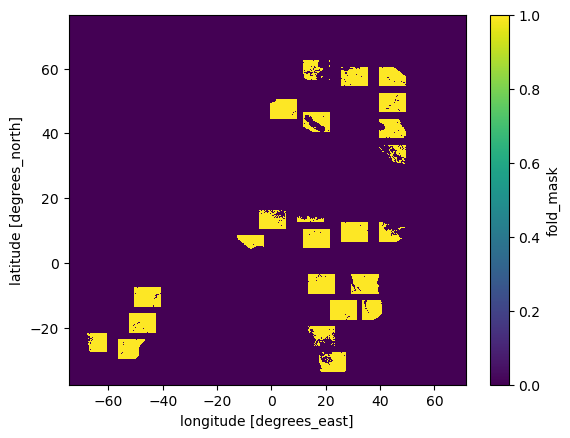

In [9]:
train_loader.dataset.mask.plot()

In [10]:
target = xr.full_like(train_loader.dataset.mask, np.nan, dtype='float32')

import traceback
try:
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
        target.loc[{'lat': xr.DataArray(b.coords.lat), 'lon': xr.DataArray(b.coords.lon)}] = i
        time.sleep(0.5)
except:
    traceback.print_exc()

  4%|█▍                                     | 84/2213 [02:30<1:03:42,  1.80s/it]
Traceback (most recent call last):
  File "/raid/scratch/tmp/ipykernel_2842/161158528.py", line 7, in <module>
    time.sleep(0.5)
KeyboardInterrupt


In [3]:
import sys
sys.path.append('../')

In [4]:
from project.modules.tcn import TCN

ImportError: cannot import name 'TCN' from 'project.modules.tcn' (/Net/Groups/BGI/people/bkraft/drought_ml/project/modules/tcn.py)

In [3]:
from project.pl_models import TemporalConvNetPL

ImportError: cannot import name 'TemporalConvNetPL' from 'project.pl_models' (/Net/Groups/BGI/people/bkraft/drought_ml/project/pl_models/__init__.py)